# Kaggle Pneumonia XRay Test

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# set sensible default parameters for matplotlib
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

plt.style.use('dark_background')

In [2]:
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *
import fastai

import wandb
wandb.init(project='Kaggle Pneumonia XRay')

plt.style.use('classic')

mean = np.zeros((1,))
std = np.zeros((1,))


<br>
<br>

## Check for an available GPU

In [3]:
import torch
print('CUDA available: '.ljust(25), torch.cuda.is_available())
print('CUDA device count: '.ljust(25), torch.cuda.device_count())

current_device = torch.cuda.current_device()
print('Current CUDA Device num: '.ljust(25), current_device)
# torch.cuda.device(current_device)
print('Current CUDA Device: '.ljust(25), torch.cuda.get_device_name(current_device))

CUDA available:           True
CUDA device count:        1
Current CUDA Device num:  0
Current CUDA Device:      GeForce RTX 2070 SUPER


In [4]:
path = './train'

<br>
<br>

## Check for Balance - the Number of Images in Each Class

In [5]:
viral_fnames = get_image_files(path + '/PVI')
bac_fnames = get_image_files(path + '/PBAC')
delta = len(bac_fnames) - len(viral_fnames)
delta

1279

## Rebalance the Dataset by Oversampling the Virus Data

(See <a href="https://arxiv.org/abs/1710.05381">A systematic study of the class imbalance problem in convolutional neural networks by Buda, et al</a> for why oversampling is often the best method for correcting imbalance issues.)

In [6]:
vi_df = pd.DataFrame(list(viral_fnames))
additional_vi = vi_df.sample(delta)
vi_df = vi_df.append(additional_vi)
upsampled_viral_fnames = L(list(vi_df.values.reshape(2772,)))


In [7]:
len(upsampled_viral_fnames * 2)

5544

In [8]:
print('len(upsampled_viral_fnames): ', len(upsampled_viral_fnames))
print('len(bac_fnames):             ', len(bac_fnames))

len(upsampled_viral_fnames):  2772
len(bac_fnames):              2772


In [9]:
def get_fnames(path):
    fnames = upsampled_viral_fnames + bac_fnames
#     fnames.append(upsampled_viral_fnames)
#     fnames.append(bac_fnames)
#     fnames.pop(0)
    return fnames * 4  # Increase the amount of data - get's augmented/randomized later


In [10]:
get_fnames('/')

(#22176) [Path('train/PVI/person1060_virus_1760.jpeg'),Path('train/PVI/person813_virus_1449.jpeg'),Path('train/PVI/person1448_virus_2468.jpeg'),Path('train/PVI/person826_virus_1462.jpeg'),Path('train/PVI/person1264_virus_2155.jpeg'),Path('train/PVI/person1341_virus_2313.jpeg'),Path('train/PVI/person1369_virus_2355.jpeg'),Path('train/PVI/person811_virus_1447.jpeg'),Path('train/PVI/person1300_virus_2240.jpeg'),Path('train/PVI/person115_virus_219.jpeg')...]

In [11]:
get_image_files(path)

(#4265) [Path('train/PBAC/person600_bacteria_2458.jpeg'),Path('train/PBAC/person87_bacteria_433.jpeg'),Path('train/PBAC/person1637_bacteria_4339.jpeg'),Path('train/PBAC/person1897_bacteria_4789.jpeg'),Path('train/PBAC/person125_bacteria_594.jpeg'),Path('train/PBAC/person992_bacteria_2920.jpeg'),Path('train/PBAC/person146_bacteria_703.jpeg'),Path('train/PBAC/person1399_bacteria_3549.jpeg'),Path('train/PBAC/person452_bacteria_1943.jpeg'),Path('train/PBAC/person364_bacteria_1659.jpeg')...]

<br>

### Create the DataBlock

In [12]:
# tfms = setup_aug_tfms([Normalize.from_stats(mean, std)])
tfms = aug_transforms(size=300, do_flip=False, batch=True)

In [13]:
imgs = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_fnames, 
    splitter=RandomSplitter(valid_pct=0.3, seed=42),
    get_y=parent_label, 
    item_tfms=Resize(300, method='bilinear')) #,
#     batch_tfms=tfms)
    
    
#     batch_tfms=Normalize.from_stats(mean=0.5, std=0.1))    
#     batch_tfms=Normalize.from_stats(*imagenet_stats))

In [14]:
# imgs.normalize()

<br>

## Resize and add basic image augmentation

In [15]:
# signs = signs.new(item_tfms=Resize(128, method=ResizeMethod.Squish), 
#                   batch_tfms=aug_transforms(mult=1.4, max_zoom=1))
# imgs = imgs.new(item_tfms=Resize(160, method=ResizeMethod.Squish))

# signs.apply_tfms(Image.flip)
# imgs.apply_tfms(Normalize.from_stats(*imagenet_stats))
# imgs.transform(Normalize.from_stats(*imagenet_stats))

<br>

### Load the data by path

In [16]:
dls = imgs.dataloaders(path, batch_size=32)

In [17]:
# means = [xb.mean(dim=(0, 2, 3)) for xb, yb in dls.train]
# stds = [xb.std(dim=(0, 2, 3)) for xb, yb in dls.train]
# mean, std = torch.stack(means).mean(dim=0), torch.stack(stds).mean(dim=0)
# print(mean, std)

<br>

### Verify the Training and Validation Batches

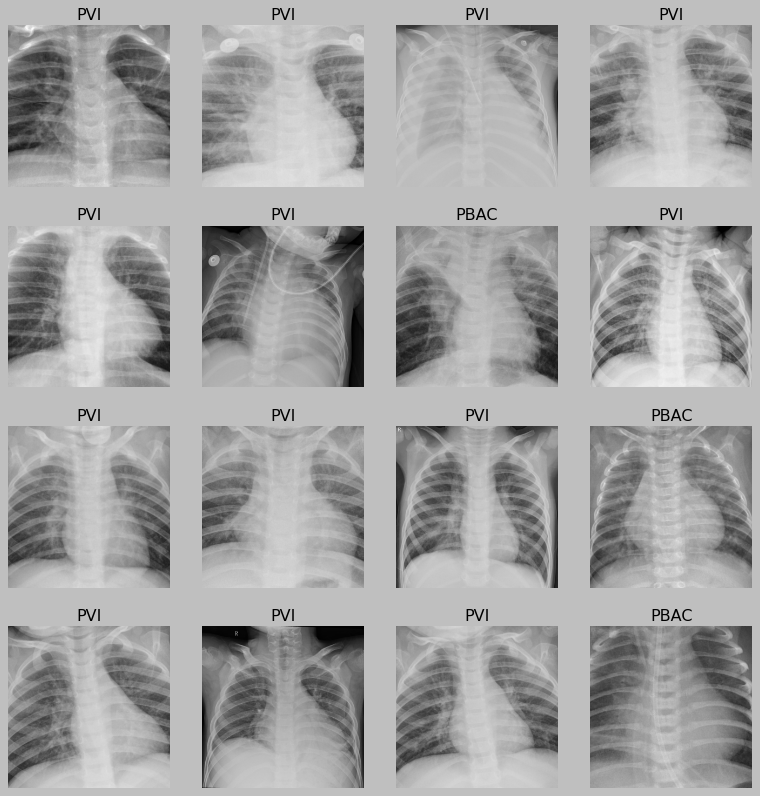

In [18]:
dls.valid.show_batch(max_n=16, nrows=4)

<br>

### Define the model (Resnet34) and fit

In [19]:
learn = cnn_learner(dls, resnet50 , metrics=[error_rate, accuracy, F1Score(), Precision(), Recall()])

<br>
<br>

#### Look at the Loss function

In [20]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

#### Look at the Optimization Function

In [21]:
learn.opt_func

<function fastai.optimizer.Adam(params, lr, mom=0.9, sqr_mom=0.99, eps=1e-05, wd=0.01, decouple_wd=True)>

### Look at the Model Architecture

In [22]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

<br>
<br>

### Define an Early Stopping and WandB Callbacks

In [23]:
early_stop = EarlyStoppingCallback(monitor='error_rate', min_delta=0.0001, patience=2)
wandb = WandbCallback(log='all')

<br>
<br>

## Find an Appropriate Learning Rate

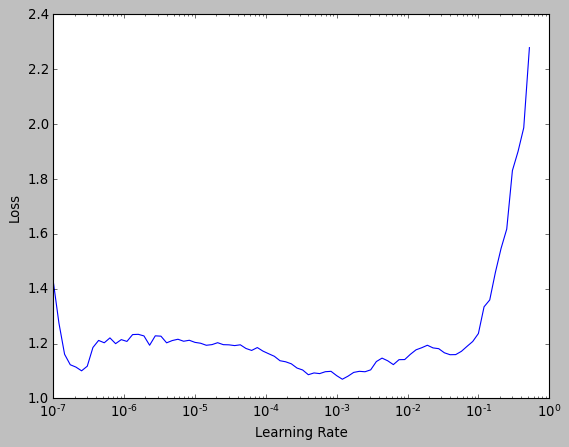

In [24]:
lr_min,lr_steep = learn.lr_find() 


In [25]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.20e-04, steepest point: 1.91e-06


<br>
<br>

## Fit the Model

In [28]:
learn.fit_one_cycle(50, cbs=[early_stop, wandb] )

epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,precision_score,recall_score,time
0,0.790431,0.561108,0.247444,0.752556,0.766657,0.730811,0.806202,04:20
1,0.679624,0.475701,0.201594,0.798406,0.812316,0.765497,0.865236,04:27
2,0.585295,0.397094,0.171377,0.828623,0.831011,0.826356,0.835719,04:23
3,0.465969,0.345230,0.145670,0.854330,0.857772,0.844753,0.871199,04:22
4,0.381664,0.285338,0.114853,0.885147,0.890888,0.854989,0.929934,04:26
5,0.315973,0.244553,0.100421,0.899579,0.900890,0.896633,0.905188,04:25
6,0.269822,0.205072,0.081780,0.918220,0.916436,0.945184,0.889386,04:17
7,0.244498,0.186970,0.079525,0.920475,0.919617,0.937713,0.902206,04:18
8,0.221036,0.164093,0.059832,0.940168,0.940114,0.948967,0.931425,04:18
9,0.188911,0.148283,0.050361,0.949639,0.948738,0.974536,0.924270,04:20


No improvement since epoch 17: early stopping


In [ ]:
# learn.fine_tune(100, base_lr=3e-4, cbs=[early_stop] )

<br>

### Plot Losses

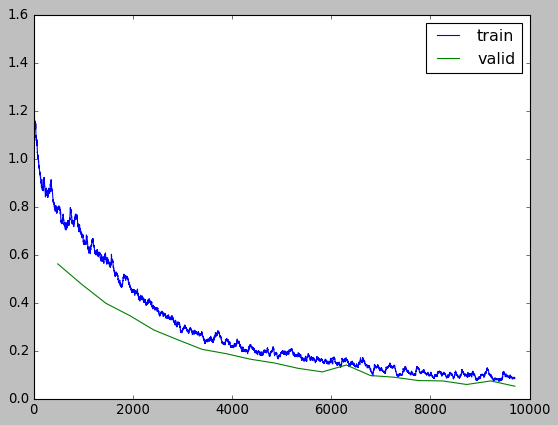

In [29]:
learn.recorder.plot_loss()

<br>

### Visualize with a confusion Matrix

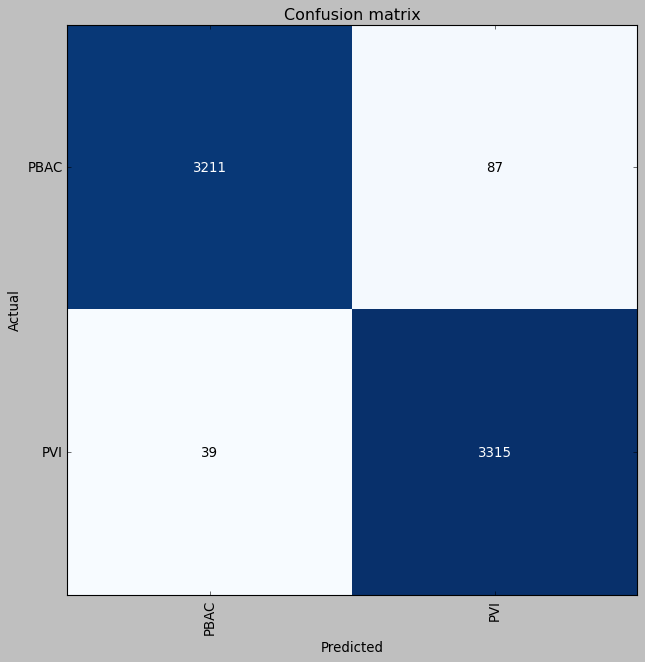

In [30]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8))

In [31]:
interp.print_classification_report()

              precision    recall  f1-score   support

        PBAC       0.99      0.97      0.98      3298
         PVI       0.97      0.99      0.98      3354

    accuracy                           0.98      6652
   macro avg       0.98      0.98      0.98      6652
weighted avg       0.98      0.98      0.98      6652



<br>

### Show the top 5 most error prone images

In [ ]:
# interp.plot_top_losses(12, nrows=4)

In [ ]:
# learn.predict('./val/NORMAL/NORMAL2-IM-1430-0001.jpeg')

In [ ]:
learn.predict('./val/PNEUMONIA/person1949_bacteria_4880.jpeg')

<br>
<br>

---

<br>
<br>

## Persist the Model

<br>
<br>

In [35]:
learn.export('models/20200103.pkl')
path = Path('models')
path.ls(file_exts='.pkl')

(#1) [Path('models/20200103.pkl')]

In [ ]:
# %cd ..

In [ ]:
# learn.save('save/200921-0121-export-resnet101-FALL-tune2ft-tune6un-tune2ft')

In [ ]:
# learn_inf = load_learner(path/'export.pkl')

In [34]:
!pwd

/home/frank/Insync/cogsci2@gmail.com/Google Drive/Study Notes/00-Personal Repos/Chest XRays/chest_xray


In [1]:
learn

NameError: name 'learn' is not defined